# A first Neural Network

We now have the basic ingredients necessary to build a neural network. We will start with a simple example to illustrate the basic concepts, namely a damped harmonic oscillator. I will then show how to use the library `Flax` to accomplish the same task.

## Damped Harmonic Oscillator

We now have the basic ingredients necessary to build a neural network. We will start with a simple example to illustrate the basic concepts, namely a damped harmonic oscillator. The equation of motion for a damped harmonic oscillator is given by
```{math}
    \frac{d^2 u}{dt^2} + 2 \alpha \omega_0 \frac{du}{dt} + \omega_0^2 u = 0,
```
where $u$ is the displacement of the oscillator, $\alpha$ is the damping coefficient, and $\omega_0$ is the natural frequency of the oscillator.

This equation can be solved exactly, with the closed form solution
```{math}
    u(t) = A e^{-\alpha \omega_0 t} \sin\left( \sqrt{1 - \alpha^2} \omega_0 t + \phi \right),
```
where $A$ is the amplitude of the oscillator, $\phi$ determines the initial phase, and $\alpha \leq 1$.

In [125]:
import jax.numpy as jnp
from jax import Array


def dampened_harmonic_oscillator(
    t: Array, omega: float, alpha: float, phi: float, A: float
) -> Array:
    inner = jnp.sqrt(1 - alpha**2) * omega * t + phi
    return A * jnp.exp(-alpha * omega * t) * jnp.sin(inner)

As parameters, we here choose $\omega_0 = 20$, $\alpha = 0.1$,  $\phi = \pi / 2$ and $A = 1$. With this, we create a partial application of the function, to simplify the interface.

In [126]:
from functools import partial
from jax import vmap

omega = 20.0
alpha = 0.1
phi = jnp.pi / 2
A = 1.0

oscillator = vmap(
    partial(dampened_harmonic_oscillator, omega=omega, alpha=alpha, phi=phi, A=A)
)

We evaluate the function at 500 points in the interval $[0, 1]$, sampling our training points at every 10th point in $[0, 0.5]$.

In [127]:
t = jnp.linspace(0, 1, 500).reshape(-1, 1)
y = oscillator(t)

t_data = t[:250:10]
y_data = y[:250:10]

Plotting the function, we see that we indeed have a damped harmonic oscillator.

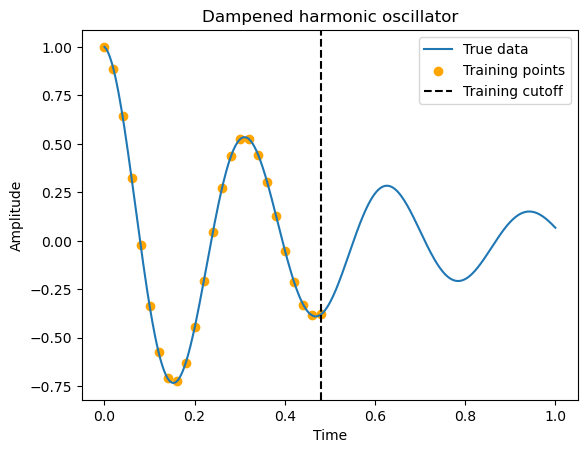

In [128]:
import matplotlib.pyplot as plt

plt.plot(t, y, label="True data")
plt.scatter(t_data, y_data, color="orange", label="Training points")
plt.axvline(t_data[-1], color="k", linestyle="--", label="Training cutoff")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Dampened harmonic oscillator")
plt.show()

## Defining the neural network

For a neural network, we need a few more ingredients.
1. We need to define a neural network architecture. We will use a simple feedforward neural network.
2. We need to define a loss function. We will use the mean squared error.
3. We need to define an optimizer. We will use gradient descent for this example.
4. We need to define a training loop.

### Neural network architecture

For a feed forward neural network, we need to define the number of layers, the number of neurons in each layer, and the activation function. We will use the `tanh` activation function for the hidden layers.

The `tanh` activation function is defined as
```{math}
    \tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}},
```
and is a smooth function that maps the input to the interval $[-1, 1]$. It can be implemented in JAX as
```{code} python
def tanh(x: Array) -> Array:
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
```
however, as it is already implemented in JAX, we can simply use `jnp.tanh`.

We then need to initialize the weights. We already saw an example of this in {ref}`MRN-random_numbers`, and we will simply use a slightly modified version of this function here.

We will use _Xavier-Glorot_ initialization {cite:p}`pmlr-v9-glorot10a`, which is defined as
```{math}
    W_{ij} \sim \mathcal{N}\left(0, \frac{2}{n_{\text{in}} + n_{\text{out}}} \right),
```
where $n_{\text{in}}$ and $n_{\text{out}}$ are the number of neurons in the input and output layers, respectively.

In [129]:
from jax import random


def initialize_params(key: Array, sizes: list[int]) -> list[Array]:
    keys = random.split(key, len(sizes))

    params = []
    for key, in_size, out_size in zip(keys, sizes[:-1], sizes[1:]):
        std = jnp.sqrt(2 / (in_size + out_size))
        W = random.normal(key, (out_size, in_size)) * std
        b = jnp.zeros(out_size)
        params.append([W, b])

    return params

For the neural network in and of itself, we will design it to handle a single input, and then utilize the `vmap` function to handle multiple inputs. This is a common pattern in JAX, and is used to vectorize the computation.

In [130]:
def neural_network(params: list[Array], x: Array) -> Array:
    activations = x
    for W, b in params:
        outputs = jnp.dot(W, activations) + b
        activations = jnp.tanh(outputs)
    return outputs

Notice that we leave the final output layer without an activation function, as we don't want to constrain the output to the interval $[-1, 1]$. (Although that would be fine in this case, as the output is in this interval.)

Next is a simple illustration of how this would be used.

In [131]:
sizes = [1, 64, 64, 1]
key = random.PRNGKey(2002)
params = initialize_params(key, sizes)

nn = vmap(neural_network, in_axes=(None, 0))
y_pred = nn(params, t_data)

We use the same pattern of applying `vmap` across the input data to evaluate the neural network at multiple points, while keeping the parameters fixed.

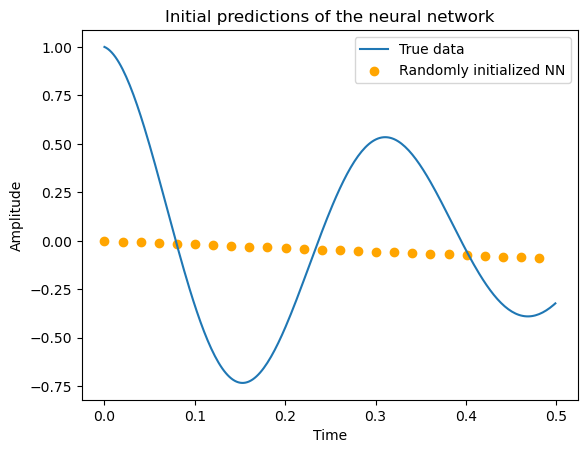

In [132]:
plt.plot(t[:250], y[:250], label="True data")
plt.scatter(t_data, y_pred, color="orange", label="Randomly initialized NN")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Initial predictions of the neural network")
plt.show()

As we see, the results are not impressive yet. We need to train the network to get better results.

### The loss function

In order to improve the neural network, we need something to define what a *good* network is. This is done by defining a loss function. For regression problems, the mean squared error (MSE) is a common choice. It is defined as
```{math}
    \text{MSE} = \frac{1}{N} \sum_{i=1}^N \lVert y_i - \hat{y}_i \rVert_2^2,
```
where $N$ is the number of data points, $y_i$ is the true value, and $\hat{y}_i$ is the predicted value.

Implementing this in JAX is straightforward:

In [133]:
def mse(predictions: Array, targets: Array) -> float:
    return jnp.mean((targets - predictions) ** 2)

As we see, the loss is quite high.

In [134]:
print(f"Current MSE: \t\t{mse(y_pred, y_data)}")
print(f"MSE against zero: \t{mse(y_data, jnp.zeros_like(y_data))}")

Current MSE: 		0.2378188818693161
MSE against zero: 	0.2392885386943817


### The optimizer

The optimizer is the algorithm that will adjust the weights of the neural network to minimize the loss function. We will use the gradient descent algorithm for this example.

The gradient descent algorithm is defined as
```{math}
    \theta_{t+1} = \theta_t - \eta \nabla_{\theta_t} L(\theta_t),
```
where $\theta_t$ are the parameters at iteration $t$, $\eta$ is the learning rate, and $L$ is the loss function, in this case MSE.

In [135]:
from jax.tree_util import tree_map


def gradient_step(
    params: list[Array], gradients: list[Array], step_size: float
) -> list[Array]:
    new_params = tree_map(lambda p, g: p - step_size * g, params, gradients)
    return new_params

Here, we need to utilize the `jax.tree_util` module to update the parameters of the neural network. This is because the parameters are stored in a nested data structure, a list of Arrays, called a PyTree in its general form.

The specifics of the implementation are not important in this case, as one generally uses a library to handle these types of operations. We will use the `Flax` and `Optax` libraries for this later.

The implementation above is equivalent to the following code:
```{code} python
def gradient_step_python(
    params: list[Array], gradients: list[Array], step_size: float
) -> list[Array]:
    new_params = [p - step_size * g for p, g in zip(params, gradients)]
    return new_params
```
however, this code cannot be compiled with `jit`.

### The training loop

As is typical with JAX, we start by considering the training loop as a combosition of functions. We will define a function `train_step` that will take a single step in the training process, and a function `train` that will run the training loop.

The `train_step` function will take the current parameters, the optimizer, the input data, and the target data, and return the updated parameters. We will use `grad` to calculate the gradient of the loss function with respect to the parameters.

In [136]:
from jax import grad


def train_step(
    params: list[Array], t_data: Array, y_data: Array, step_size: float
) -> list[Array]:
    nn = vmap(neural_network, in_axes=(None, 0))

    def loss_fn(params: list[Array]) -> float:
        y_pred = nn(params, t_data)
        return mse(y_pred, y_data)

    grads = grad(loss_fn)(params)
    new_params = gradient_step(params, grads, step_size)
    return new_params

Then, the `train` function will run the training loop for a number of epochs, and return the trained parameters.

In [141]:
from jax import jit


def train(
    initial_params: list[Array],
    t_data: Array,
    y_data: Array,
    step_size: float,
    num_steps: int,
) -> list[Array]:
    step = jit(train_step)

    params = initial_params
    for epoch in range(num_steps):
        params = step(params, t_data, y_data, step_size)
        if epoch % 1000 == 0:
            loss = mse(nn(params, t_data), y_data)
            print(f"Epoch {epoch}, loss: {loss}")

    return params

In [142]:
sizes = [1, 64, 64, 1]
initial_params = initialize_params(random.PRNGKey(2002), sizes)
step_size = 0.1
num_steps = 10000

params_trained = train(initial_params, t_data, y_data, step_size, num_steps)

Epoch 0, loss: 0.2339489907026291
Epoch 1000, loss: 0.22597074508666992
Epoch 2000, loss: 0.22579987347126007
Epoch 3000, loss: 0.22520382702350616
Epoch 4000, loss: 0.2205437868833542
Epoch 5000, loss: 0.13792656362056732
Epoch 6000, loss: 0.024582969024777412
Epoch 7000, loss: 0.004380376078188419
Epoch 8000, loss: 0.003661276074126363
Epoch 9000, loss: 0.0031391107477247715


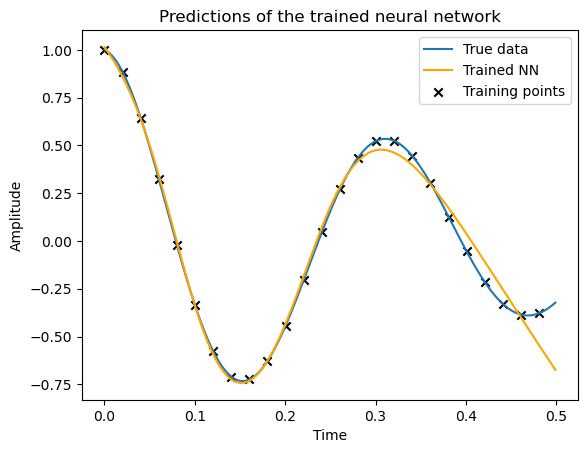

In [149]:
y_pred = nn(params_trained, t[:250])

plt.plot(t[:250], y[:250], label="True data")
plt.plot(t[:250], y_pred, color="orange", label="Trained NN")
plt.scatter(t_data, y_data, color="k", marker="x", label="Training points")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Predictions of the trained neural network")
plt.show()

As we see, we are now able to achieve a much better fit to the data. However, note that there is still a noticeable difference between the predicted and true values, and we are evaluating the network on the training data.

Checking the fit on the whole domain, we see a different story.

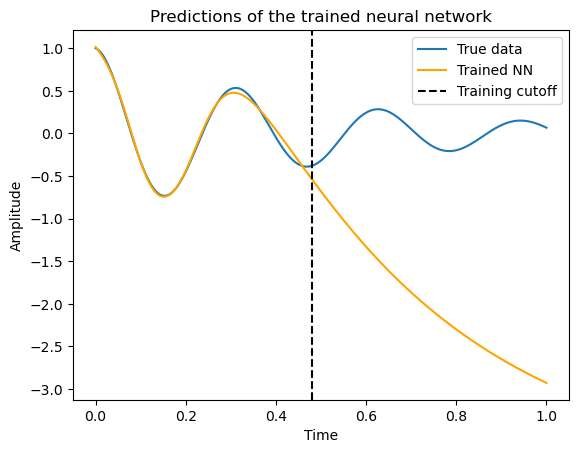

In [150]:
plt.plot(t, y, label="True data")
plt.plot(t, nn(params_trained, t), color="orange", label="Trained NN")
plt.axvline(t_data[-1], color="k", linestyle="--", label="Training cutoff")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Predictions of the trained neural network")
plt.show()

The network was is other words unable to generalize to the underlying function, even though it was able to fit the training data well.

## Using Flax

The `Flax` library is a high-level neural network library built on top of JAX. It provides a more user-friendly interface to define neural networks, similar to PyTorch and TensorFlow.

We will now show how to use `Flax` to accomplish the same task.

### Defining the neural network

We start by defining the neural network architecture. We will use the same architecture as before.

In [ ]:
from flax import nnx


class Linear(nnx.Module):
    def __init__(self, in_size: int, out_size: int, *, rngs: nnx.Rngs) -> None:
        weights = random.normal(rngs.param(), (out_size, in_size)) * jnp.sqrt(
            2 / (in_size + out_size)
        )
        biases = jnp.zeros(out_size)

        self.W = nnx.Param(weights)
        self.b = nnx.Param(biases)

    def __call__(self, x: Array) -> Array:
        return self.W.value @ x + self.b.value


class MLP(nnx.Module):
    def __init__(
        self, in_size: int, hidden_size: int, out_size: int, *, rngs: nnx.Rngs
    ) -> None:
        self.linear1 = Linear(in_size, hidden_size, rngs=rngs)
        self.linear2 = Linear(hidden_size, hidden_size, rngs=rngs)
        self.linear3 = Linear(hidden_size, out_size, rngs=rngs)

    def __call__(self, x: Array) -> Array:
        x = nnx.tanh(self.linear1(x))
        x = nnx.tanh(self.linear2(x))
        return self.linear3(x)

## References
```{bibliography}
:style: unsrt
```